In [1]:
%load_ext autoreload
%autoreload 2
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import Analysis
import bayesianchangepoint as bcp

In [3]:
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
nb_sujet = len(list_sujet)

In [4]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
            
BET = {}
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            BET[liste[x][1]] = b

# Scaling Data

In [5]:
e = Analysis(observer='AM', mode='enregistrement')
Full = e.Full_list(modes_bcp=None)

In [6]:
scal_va_sujet, scal_va_full = {}, []
scal_bet_sujet, scal_bet_full = {}, []

va_full, bet_full = [], []
for x in list_sujet :
    bet = []
    for block in range(BET[x]['N_blocks']) :
        bet.extend((BET[x]['results'][:,block]+1)/2)
    
    bet_full.extend(bet)
    va_full.extend(list(Full['va'][Full.sujet==x]))
    
    scal_bet_sujet[x] = np.sort(bet)
    scal_va_sujet[x] = np.sort(list(Full['va'][Full.sujet==x]))

scal_va_full = np.sort(va_full)
scal_bet_full = np.sort(bet_full)

In [7]:
new_proba_full = np.linspace(0,1,len(scal_va_full))

new_va_sujet, new_va_full = {}, {}
new_bet_sujet, new_bet_full = {}, {}


for x in list_sujet :
    N_trials = BET[x]['N_trials']
    
    new_proba_sujet = np.linspace(0, 1, len(scal_va_sujet[x]))
    va_sujet = list(Full['va'][Full.sujet==x])
    
    
    nb_trial = 0
    
    new_va_sujet[x], new_va_full[x] = [], []
    new_bet_sujet[x], new_bet_full[x] = [], []
    
    for block in range(3) :
        new_va_sujet[x].append([])
        new_va_full[x].append([])
        
        new_bet_sujet[x].append([])
        new_bet_full[x].append([])
        
        
        va = va_sujet[nb_trial : N_trials + nb_trial*block]
        bet = (BET[x]['results'][:,block]+1)/2
        
        
        for trial in range(len(va)) :
            p = []
            for t in range(len(scal_va_sujet[x])) :
                if scal_va_sujet[x][t] == va[trial] :
                    p.append(new_proba_sujet[t])
            new_va_sujet[x][block].append(np.mean(p))
            
            p = []
            for t in range(len(scal_va_full)) :
                if scal_va_full[t] == va[trial] :
                    p.append(new_proba_full[t])
            new_va_full[x][block].append(np.mean(p))
       

        for trial in range(len(bet)) :
            p = []
            for t in range(len(scal_bet_sujet[x])) :
                if scal_bet_sujet[x][t] == bet[trial] :
                    p.append(new_proba_sujet[t])
            new_bet_sujet[x][block].append(np.mean(p))

            p = []
            for t in range(len(scal_bet_full)) :
                if scal_bet_full[t] == bet[trial] :
                    p.append(new_proba_full[t])
            new_bet_full[x][block].append(np.mean(p))
    
    
        nb_trial = nb_trial + N_trials

# Variation de h

In [8]:
from lmfit import  Model, Parameters
from lmfit import minimize

In [9]:
def fct_BCP(x, h) :

    p_bar, r_bar, beliefs = bcp.inference(x, h=h, p0=.5, r0=1.)
    p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=.5, fixed_window_size=40)#, mode='mean')
    
    return p_hat

In [10]:
'''def KL_distance(p_data, p_hat):
    distance = p_data * np.log2(p_data + 1.*(p_data==0.)) - p_data * np.log2(p_hat)
    distance += (1-p_data) * np.log2(1-p_data + 1.*(p_data==1.)) - (1-p_data) * np.log2(1-p_hat)
    
    return distance'''

def KL_distance(p_data, p_hat):
    distance = p_hat * np.log2(p_hat) - p_hat * np.log2(p_data + 1.*(p_data==0.))
    distance += (1-p_hat) * np.log2(1-p_hat) - (1-p_hat) * np.log2(1-p_data + 1.*(p_data==1.))
    return distance

def residual(params, x, data):
    h = params['h']
    model = fct_BCP(x, h)
    
    return KL_distance(data, model)

def fit(h, x, bet, va):
    
    x = np.array(x)
    bet = np.array(bet)
    va = np.array(va)


    params = Parameters()
    params.add('h', value=h, min=0, max=1)

    result_res = minimize(residual, params, args=(x, bet), nan_policy='omit')
    result_v_ant = minimize(residual, params, args=(x, va), nan_policy='omit')
    
    h_bet = result_res.params['h'].value
    h_va = result_v_ant.params['h'].value
    
    return h_bet, h_va

In [11]:
h_bet, h_va = {}, {}

for l in ['pause', 'block', 'sujet'] :
    h_bet[l], h_va[l] = [], []

for x, sujet in enumerate(list_sujet) :

    print(sujet)
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []

    p = BET[sujet]['p']
    tau = BET[sujet]['N_trials']/5.
    h = 1./tau 

    for l in ['block', 'pause'] :
        h_bet[l].append([])
        h_va[l].append([])

    for block in range(BET[sujet]['N_blocks']):
        va = new_va_full[sujet][block] #new_va_sujet[x][block]
        bet = new_bet_full[sujet][block] #new_bet_sujet[x][block]
        
        
        prob_block = p[:, block, 0]
        h_b, h_v = fit(h, prob_block, bet, va)

        h_bet['block'][x].append(h_b)
        h_va['block'][x].append(h_v)

        prob_sujet.extend(p[:, block, 0])
        bet_sujet.extend(bet)
        v_anti_sujet.extend(va)
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            va_p = va[liste[a]:liste[a+1]]
            bet_p = bet[liste[a]:liste[a+1]]
            prob_pause = p[liste[a]:liste[a+1], block, 0]
            
            h_b, h_v = fit(h, prob_pause, bet_p, va_p)

            h_bet['pause'][x].append(h_b)
            h_va['pause'][x].append(h_v)
                

    h_b, h_v = fit(h, prob_sujet, bet_sujet, v_anti_sujet)
    h_bet['sujet'].append(h_b)
    h_va['sujet'].append(h_v)

AM
BMC
CS
DC
FM
IP
LB
OP
RS
SR
TN
YK


## evaluating the best hazard rate using a likelihood score between the predicted biases using different values of the hazard rate

In [ ]:
import matplotlib.gridspec as gridspec

def evaluating (data_eval, h_eval):
    
    for x, sujet in enumerate(list_sujet) :
        print(sujet)

        fig = plt.figure(figsize=(20,20*1/2))
        axs = gridspec.GridSpec(3, 1, hspace=0.4)

        mode = 'mean'

        N_trials, N_blocks = BET[sujet]['N_trials'], BET[sujet]['N_blocks']

        tau_true = 40. # N_trials/10.
        h_true = 1./tau_true

        Jeffreys = True
        p0, r0 = .5, 2. - Jeffreys


        nb_trial = 0
        for block in range(N_blocks) :
            gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=axs[block], wspace=0.5)
            ax1 = plt.Subplot(fig, gs1[:,:-1])
            ax2 = plt.Subplot(fig, gs1[:,-1])
            fig.add_subplot(ax1)
            fig.add_subplot(ax2)


            data = data_eval[sujet][block]
            h_sujet = h_eval['block'][x][block]

            bino = np.array(list(Full['bino'][Full.sujet==sujet])[nb_trial:N_trials+nb_trial*block])
            p = np.array(list(Full['proba'][Full.sujet==sujet])[nb_trial:N_trials+nb_trial*block])

            distance = np.zeros(N_trials)
            p_hat = np.zeros(N_trials)
            p_low, p_sup = np.zeros_like(distance), np.zeros_like(distance)


            p_bar, r, beliefs = bcp.inference(bino, h=h_sujet, p0=p0, r0=r0, verbose=False)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode, p0=p0)
            from scipy.stats import beta
            for trial in range(N_trials):
                a = p_hat[trial]*(r_hat[trial])
                b = (1-p_hat[trial])*(r_hat[trial])
                rv = beta(a, b)
                p_low[trial], p_sup[trial] = rv.ppf([.05, .95])
                distance[trial] = KL_distance(data[trial], p_hat[trial])

            distance = np.exp(-distance/np.median(distance))

            ax1.plot(range(N_trials), data, c='k', lw=1, alpha=.9)
            ax1.plot(range(N_trials), p_hat, 'r', lw=1, alpha=.5)
            ax1.scatter(range(N_trials), p_hat, c=distance, vmin=distance.min(), vmax=distance.max(), alpha=1., cmap=plt.get_cmap('RdGy'))  # coolwarm

            ax1.fill_between(range(N_trials), np.zeros_like(p), p, lw=.5, alpha=0.2, facecolor='k', step='pre')
            ax1.fill_between(range(N_trials), p_sup, p_low, lw=.2, alpha=0.2, facecolor='r', step='mid')
            ax1.plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
            ax1.plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
            ax1.set_ylim(-0.1, 1.1)

            #-------------------------------------------------------------------------
            N_scan = 100  
            hs = np.logspace(-1, 1, N_scan, base=N_scan)/N_scan

            full_distance = np.zeros(N_scan)
            for i_scan, h_ in enumerate(hs):
                p_bar, r, beliefs = bcp.inference(bino, h=h_, p0=p0, r0=r0, verbose=False)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode, p0=p0)
                d_ = KL_distance(np.array(data), p_hat)

                full_distance[i_scan] = np.mean(d_)

            ax2.plot(hs, full_distance, 'k')
            ax2.vlines(h_sujet, ymin=np.nanmin(full_distance), ymax=np.nanmax(full_distance), colors='k', linestyle='--', lw=2)

            h_opt = hs[np.argmin(full_distance)]
            ax2.vlines(h_opt, ymin=np.nanmin(full_distance), ymax=np.nanmax(full_distance), colors='r', linestyle='--', lw=2)
            ax2.set_xscale("log")
            ax2.set_ylim(0)
            ax2.set_xlabel('Hazard rate')
            ax2.set_ylabel('distance')

            print('block', block, '--> tau_sujet=%.1f ,'%(1/h_sujet), 'h_sujet=%.5f ,'%(h_sujet), 'tau_opt=%.1f ,'%(1/h_opt), 'h_opt=%.5f'%(h_opt))

            nb_trial = nb_trial+N_trials

        plt.show() 

### BET

AM
block 0 --> tau_sujet=1726.6 , h_sujet=0.00058 , tau_opt=1873.8 , h_opt=0.00053
block 1 --> tau_sujet=2.6 , h_sujet=0.37987 , tau_opt=4.0 , h_opt=0.24771
block 2 --> tau_sujet=189.0 , h_sujet=0.00529 , tau_opt=152.0 , h_opt=0.00658


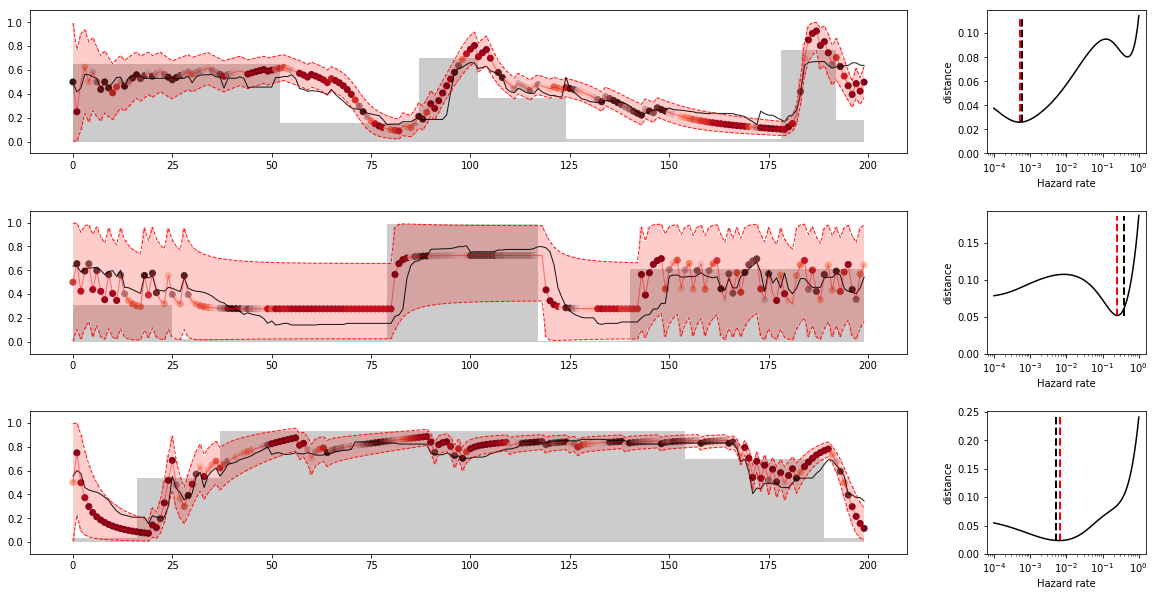

BMC
block 0 --> tau_sujet=38.8 , h_sujet=0.02578 , tau_opt=37.6 , h_opt=0.02656
block 1 --> tau_sujet=6.5 , h_sujet=0.15270 , tau_opt=14.8 , h_opt=0.06734
block 2 --> tau_sujet=96.1 , h_sujet=0.01041 , tau_opt=31.3 , h_opt=0.03199


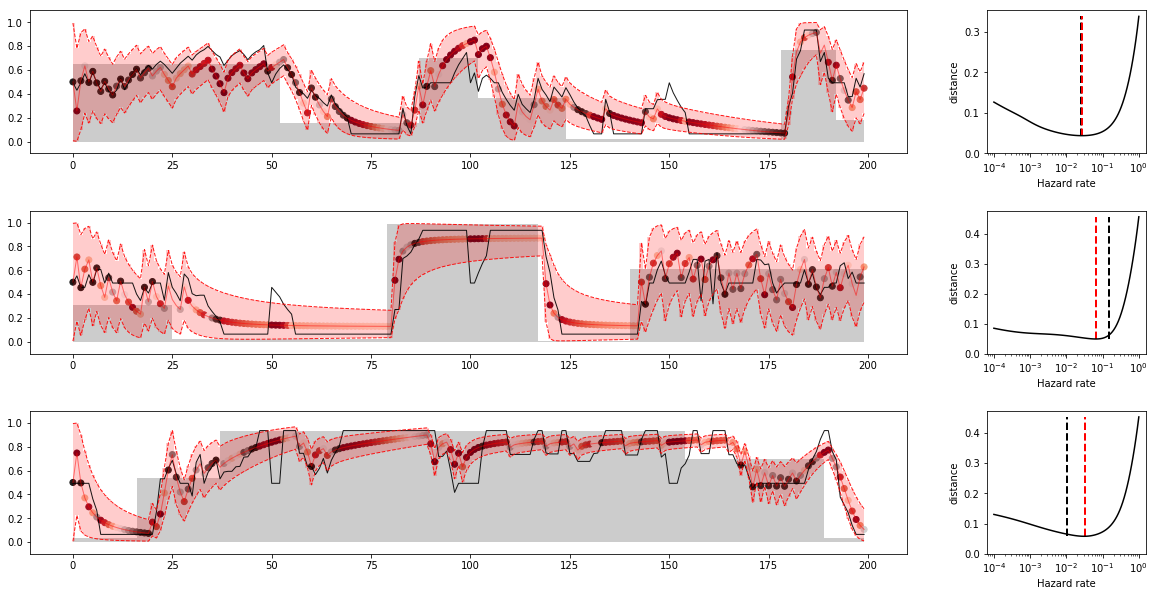

CS
block 0 --> tau_sujet=1.6 , h_sujet=0.61874 , tau_opt=2.5 , h_opt=0.39442
block 1 --> tau_sujet=4.2 , h_sujet=0.23873 , tau_opt=6.4 , h_opt=0.15557
block 2 --> tau_sujet=4.8 , h_sujet=0.20949 , tau_opt=3.7 , h_opt=0.27186


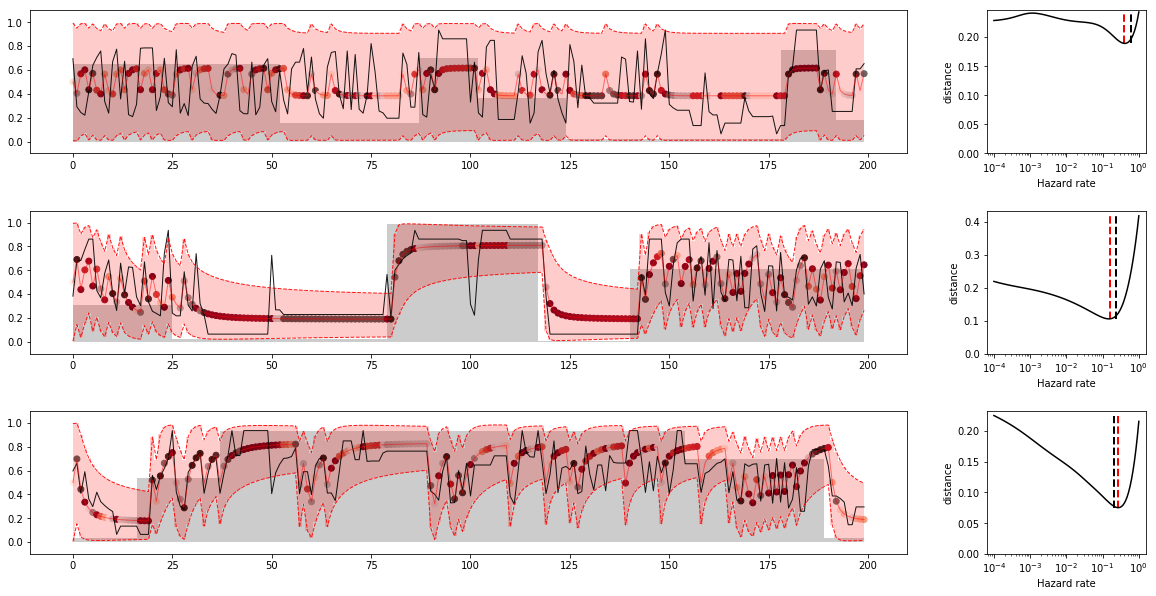

DC
block 0 --> tau_sujet=1.7 , h_sujet=0.59520 , tau_opt=2.1 , h_opt=0.47508
block 1 --> tau_sujet=2.3 , h_sujet=0.43101 , tau_opt=3.4 , h_opt=0.29836
block 2 --> tau_sujet=5.1 , h_sujet=0.19772 , tau_opt=4.4 , h_opt=0.22570


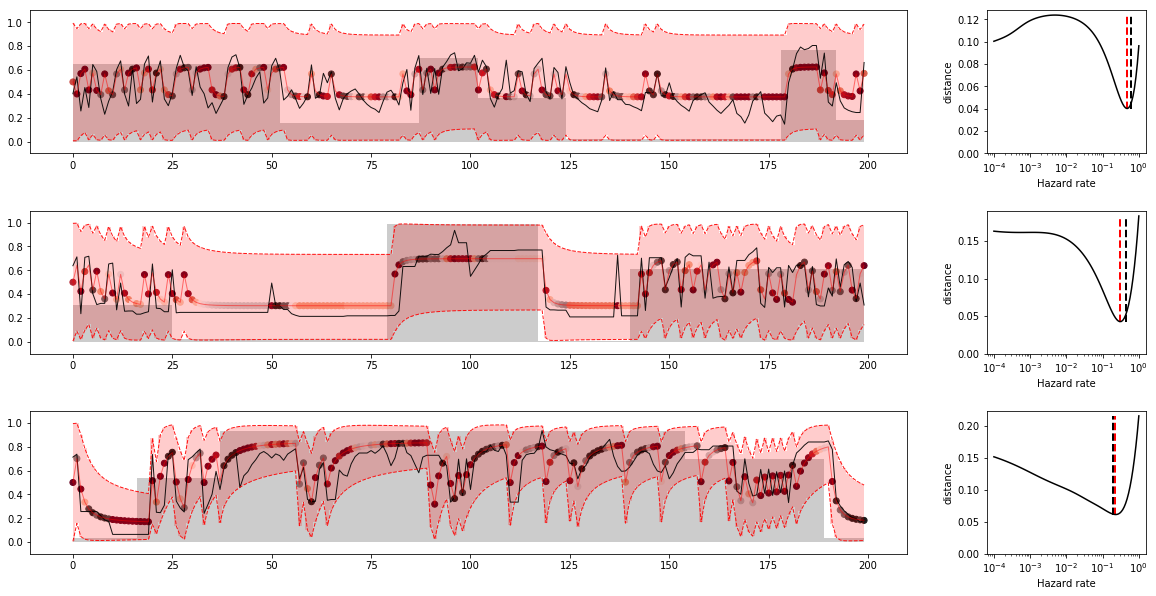

FM
block 0 --> tau_sujet=3.1 , h_sujet=0.32405 , tau_opt=10000.0 , h_opt=0.00010
block 1 --> tau_sujet=5.6 , h_sujet=0.18009 , tau_opt=12.3 , h_opt=0.08111
block 2 --> tau_sujet=17.7 , h_sujet=0.05635 , tau_opt=16.3 , h_opt=0.06136


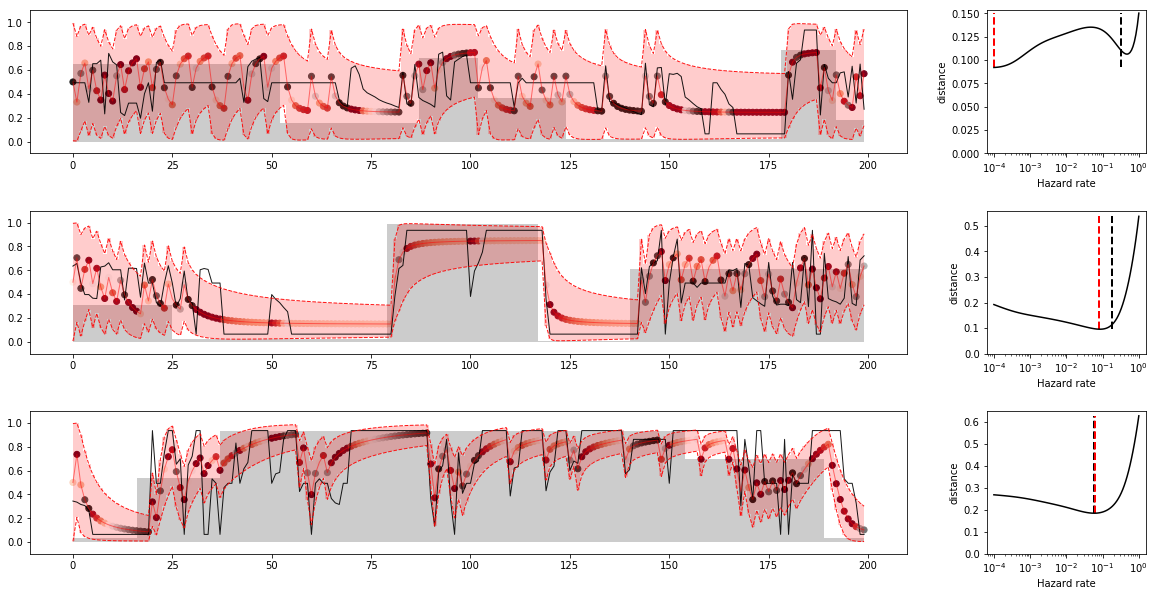

IP
block 0 --> tau_sujet=14757.0 , h_sujet=0.00007 , tau_opt=10000.0 , h_opt=0.00010
block 1 --> tau_sujet=5.6 , h_sujet=0.17857 , tau_opt=9.3 , h_opt=0.10723
block 2 --> tau_sujet=39.8 , h_sujet=0.02515 , tau_opt=3.1 , h_opt=0.32745


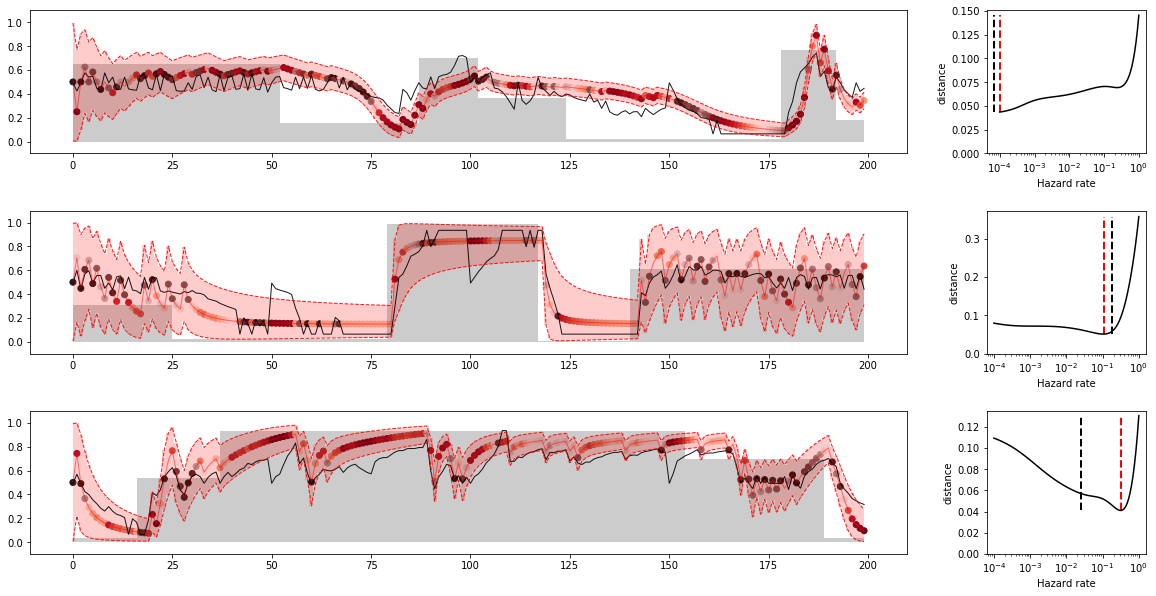

LB
block 0 --> tau_sujet=250.4 , h_sujet=0.00399 , tau_opt=183.1 , h_opt=0.00546
block 1 --> tau_sujet=3.6 , h_sujet=0.27904 , tau_opt=4.4 , h_opt=0.22570
block 2 --> tau_sujet=35.7 , h_sujet=0.02803 , tau_opt=26.0 , h_opt=0.03854


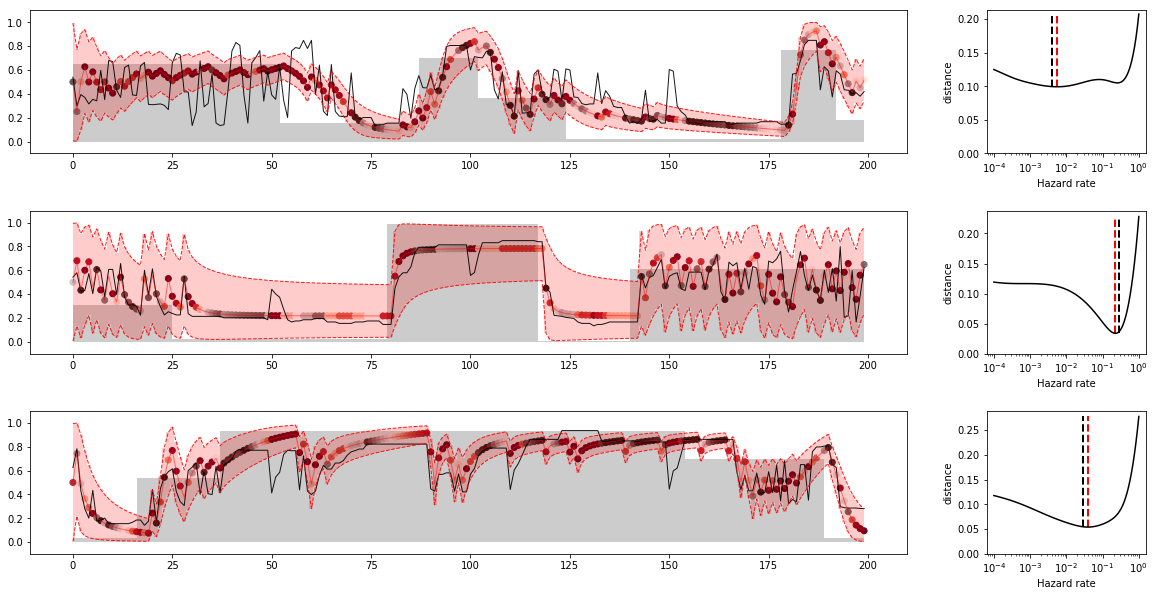

OP
block 0 --> tau_sujet=5989.4 , h_sujet=0.00017 , tau_opt=6892.6 , h_opt=0.00015
block 1 --> tau_sujet=103.3 , h_sujet=0.00968 , tau_opt=37.6 , h_opt=0.02656
block 2 --> tau_sujet=12.1 , h_sujet=0.08280 , tau_opt=12.3 , h_opt=0.08111


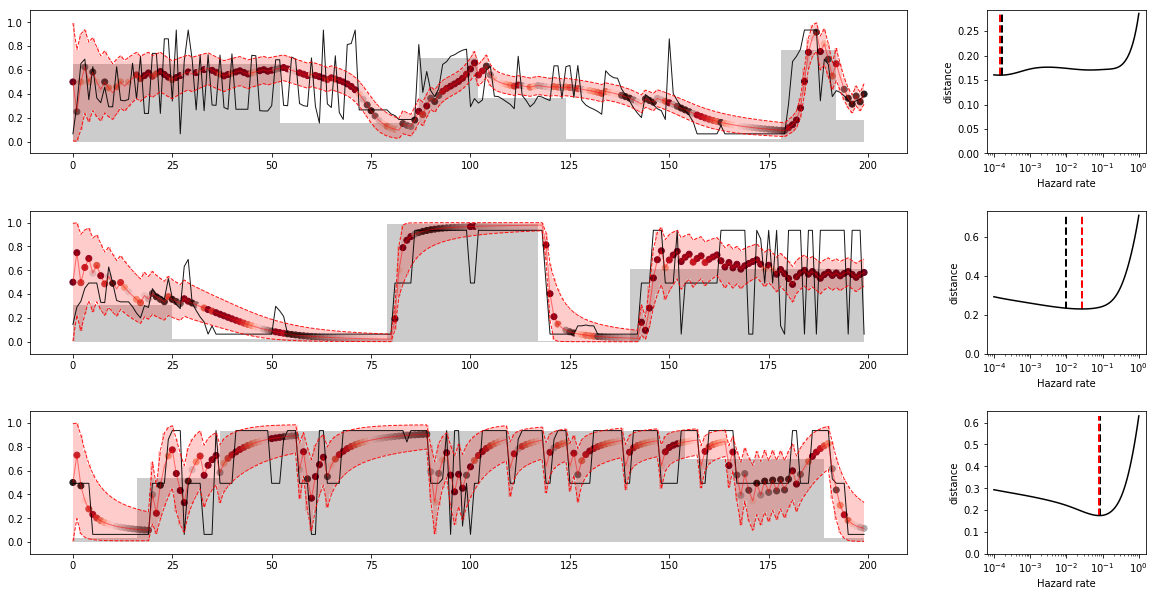

RS
block 0 --> tau_sujet=33637.9 , h_sujet=0.00003 , tau_opt=2.3 , h_opt=0.43288
block 1 --> tau_sujet=2.2 , h_sujet=0.46293 , tau_opt=4.4 , h_opt=0.22570
block 2 --> tau_sujet=1.7 , h_sujet=0.58932 , tau_opt=183.1 , h_opt=0.00546


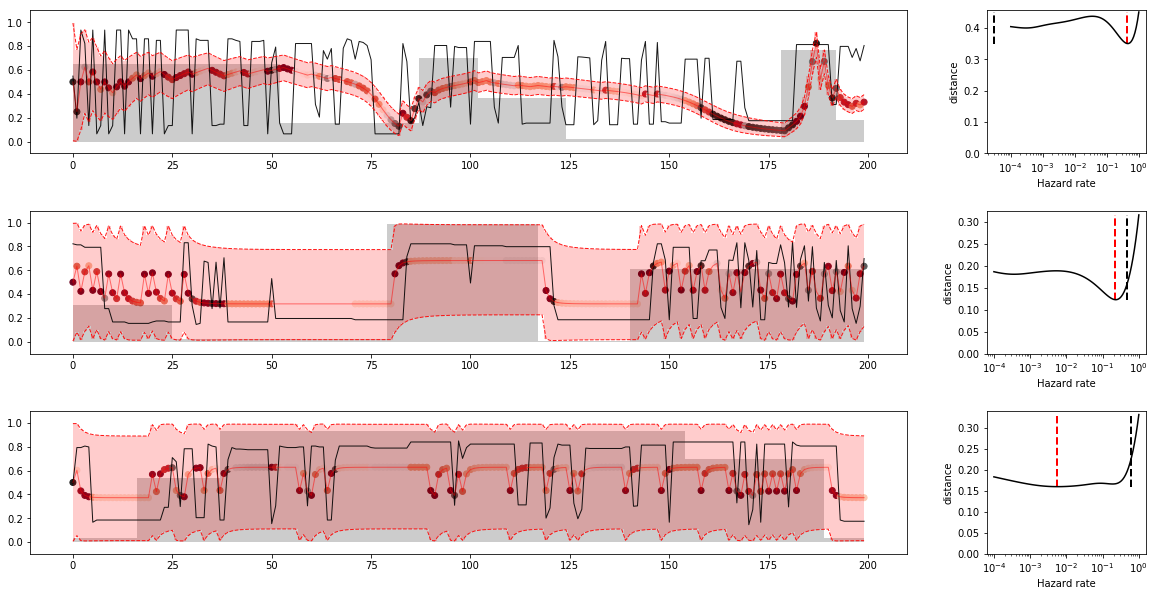

SR
block 0 --> tau_sujet=680.4 , h_sujet=0.00147 , tau_opt=115.0 , h_opt=0.00870
block 1 --> tau_sujet=3.7 , h_sujet=0.27106 , tau_opt=5.3 , h_opt=0.18738
block 2 --> tau_sujet=577.0 , h_sujet=0.00173 , tau_opt=385.4 , h_opt=0.00260


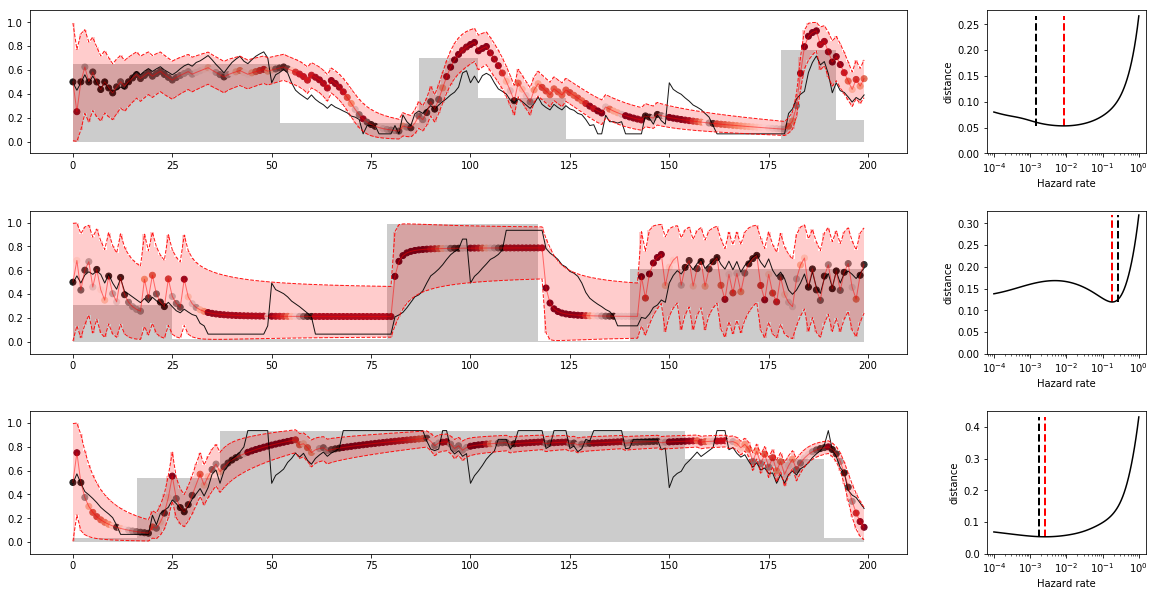

TN
block 0 --> tau_sujet=18.0 , h_sujet=0.05555 , tau_opt=34.3 , h_opt=0.02915
block 1 --> tau_sujet=20.2 , h_sujet=0.04954 , tau_opt=21.5 , h_opt=0.04642
block 2 --> tau_sujet=44.2 , h_sujet=0.02260 , tau_opt=41.3 , h_opt=0.02420


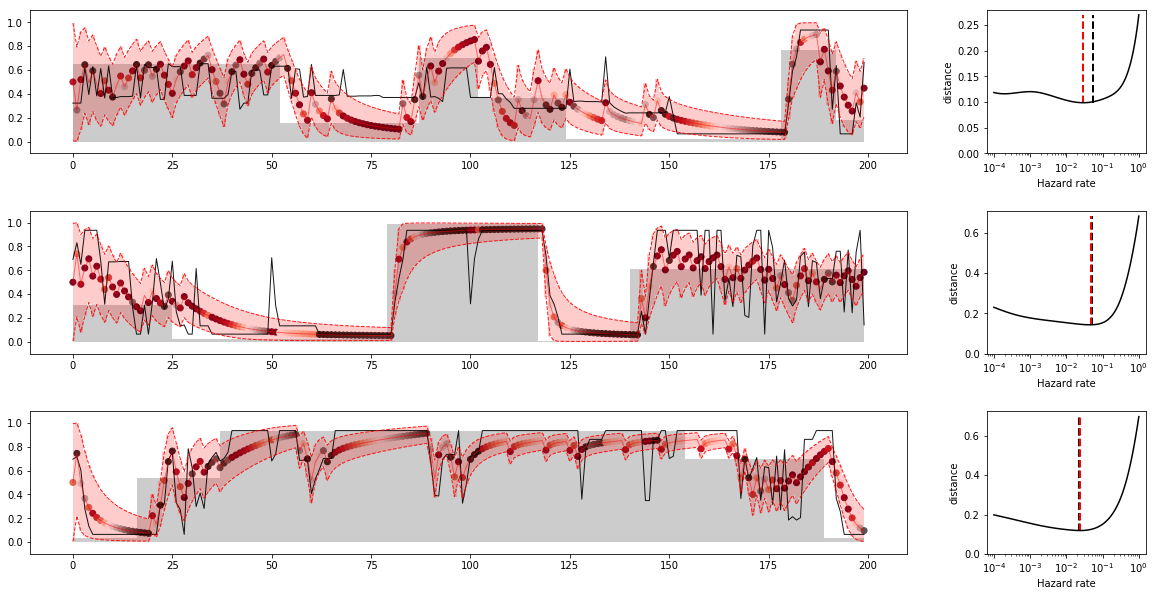

YK
block 0 --> tau_sujet=9208.3 , h_sujet=0.00011 , tau_opt=95.5 , h_opt=0.01048
block 1 --> tau_sujet=29.9 , h_sujet=0.03347 , tau_opt=17.9 , h_opt=0.05591
block 2 --> tau_sujet=14.0 , h_sujet=0.07166 , tau_opt=23.6 , h_opt=0.04229


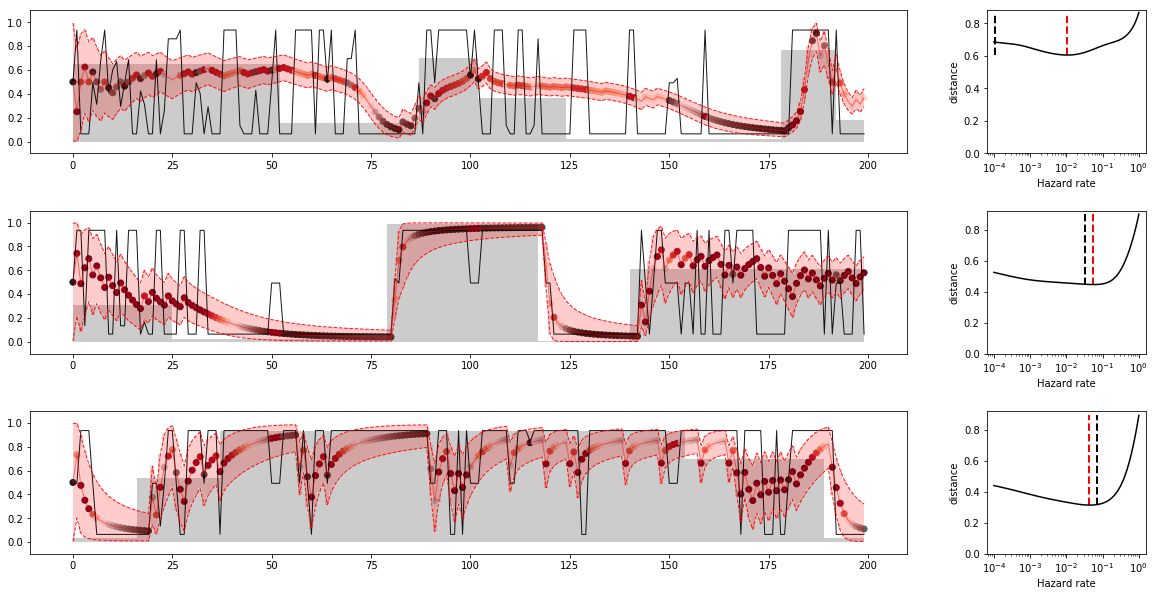

In [13]:
evaluating (new_bet_full, h_bet)

### VA

AM
block 0 --> tau_sujet=22.0 , h_sujet=0.04541 , tau_opt=17.9 , h_opt=0.05591
block 1 --> tau_sujet=9.0 , h_sujet=0.11060 , tau_opt=13.5 , h_opt=0.07391
block 2 --> tau_sujet=9.4 , h_sujet=0.10606 , tau_opt=9.3 , h_opt=0.10723


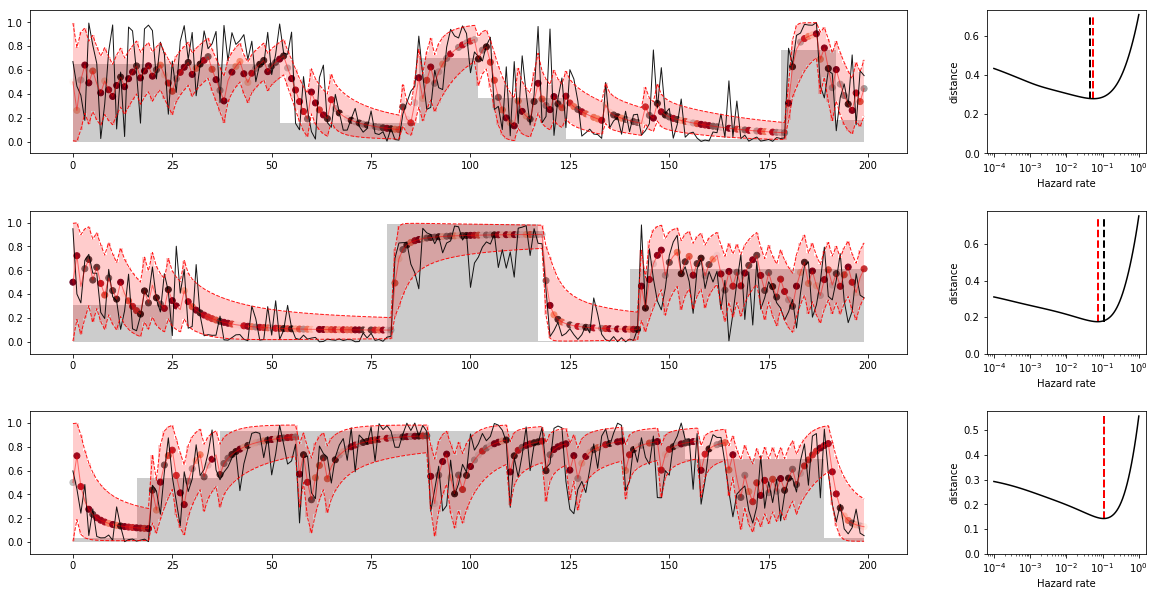

BMC
block 0 --> tau_sujet=2.3 , h_sujet=0.43554 , tau_opt=3.4 , h_opt=0.29836
block 1 --> tau_sujet=8.6 , h_sujet=0.11617 , tau_opt=7.1 , h_opt=0.14175
block 2 --> tau_sujet=14.2 , h_sujet=0.07038 , tau_opt=14.8 , h_opt=0.06734


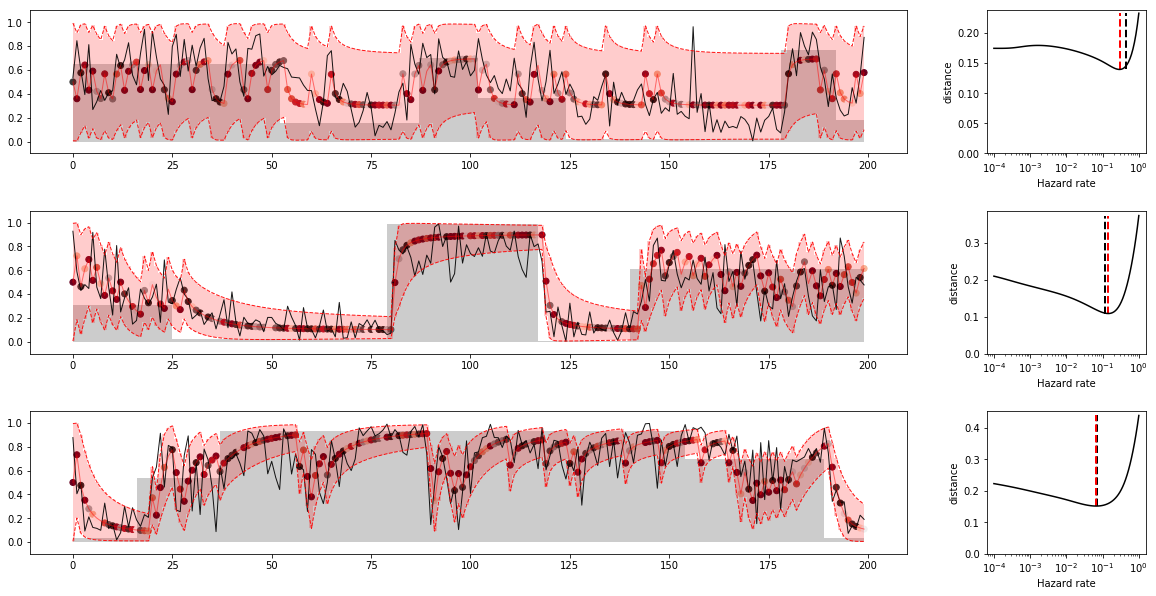

CS
block 0 --> tau_sujet=9.1 , h_sujet=0.10951 , tau_opt=5.3 , h_opt=0.18738
block 1 --> tau_sujet=3.7 , h_sujet=0.27387 , tau_opt=12.3 , h_opt=0.08111
block 2 --> tau_sujet=547.0 , h_sujet=0.00183 , tau_opt=17.9 , h_opt=0.05591


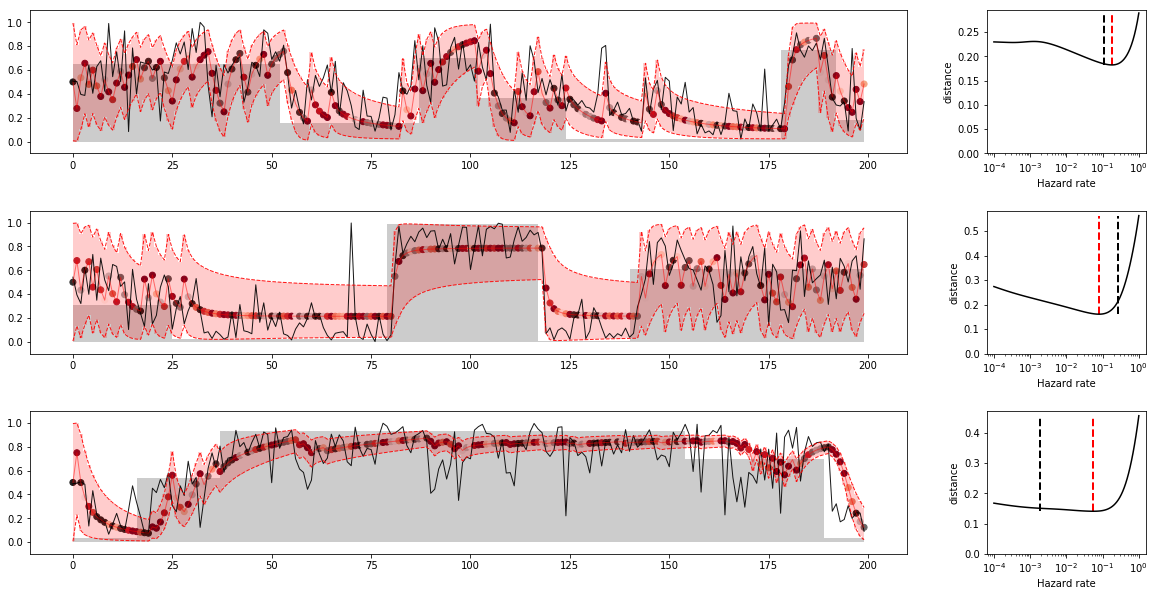

DC
block 0 --> tau_sujet=3.4 , h_sujet=0.29188 , tau_opt=5.3 , h_opt=0.18738
block 1 --> tau_sujet=2.2 , h_sujet=0.46279 , tau_opt=2.8 , h_opt=0.35938
block 2 --> tau_sujet=1.7 , h_sujet=0.59724 , tau_opt=1.9 , h_opt=0.52140


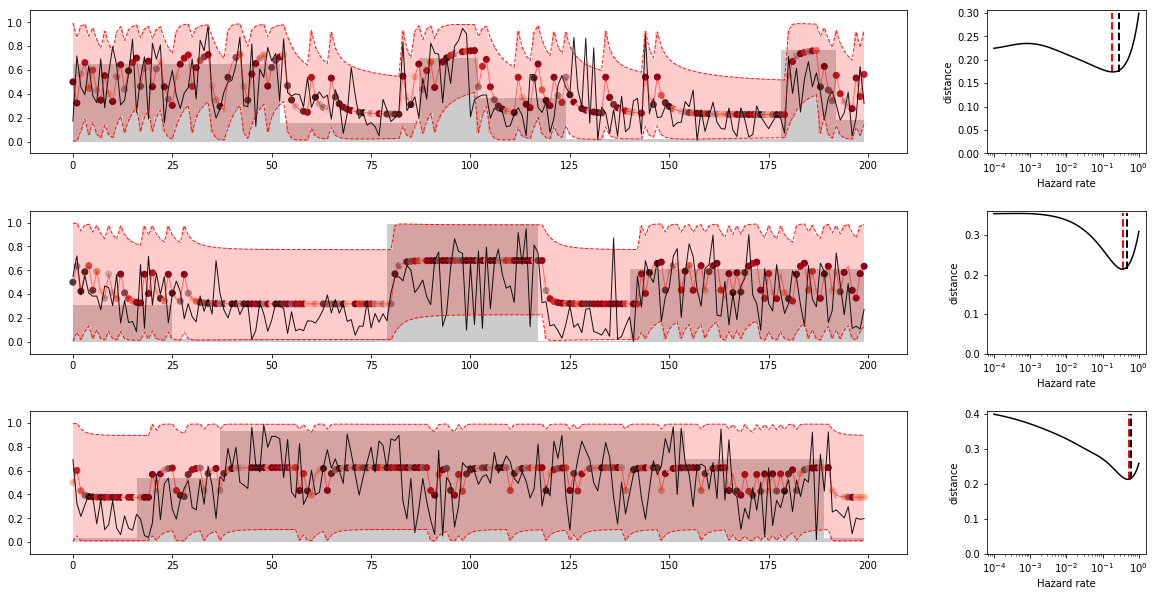

FM
block 0 --> tau_sujet=6.1 , h_sujet=0.16506 , tau_opt=9.3 , h_opt=0.10723
block 1 --> tau_sujet=5.3 , h_sujet=0.18699 , tau_opt=5.9 , h_opt=0.17074
block 2 --> tau_sujet=2.7 , h_sujet=0.36898 , tau_opt=2.8 , h_opt=0.35938


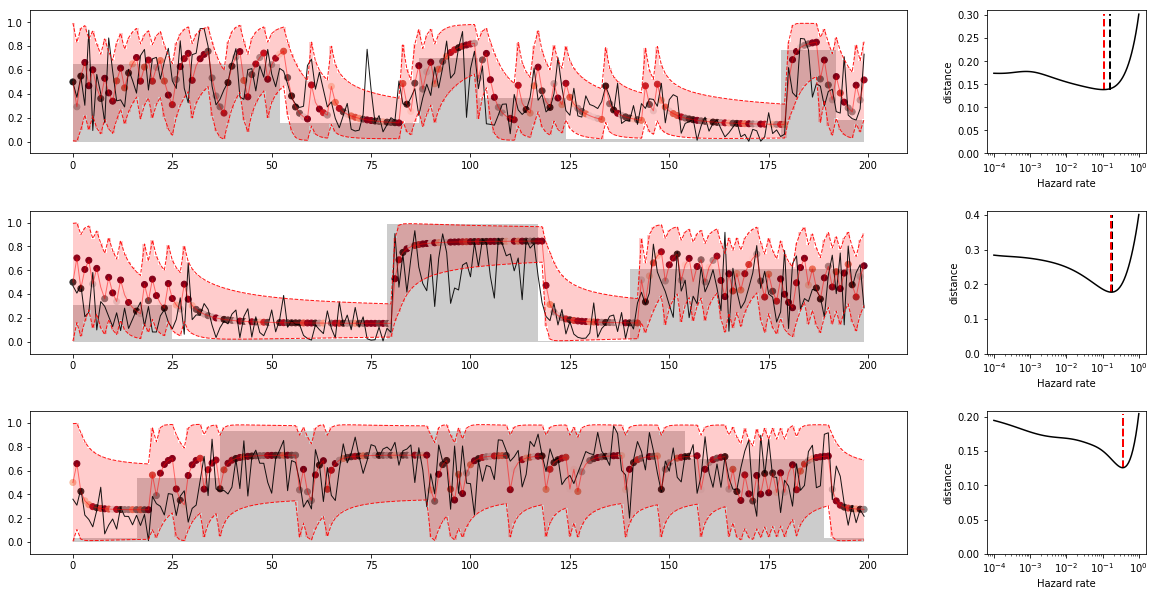

IP
block 0 --> tau_sujet=5.0 , h_sujet=0.20155 , tau_opt=5.3 , h_opt=0.18738
block 1 --> tau_sujet=6.2 , h_sujet=0.16045 , tau_opt=5.9 , h_opt=0.17074
block 2 --> tau_sujet=182.9 , h_sujet=0.00547 , tau_opt=265.6 , h_opt=0.00376


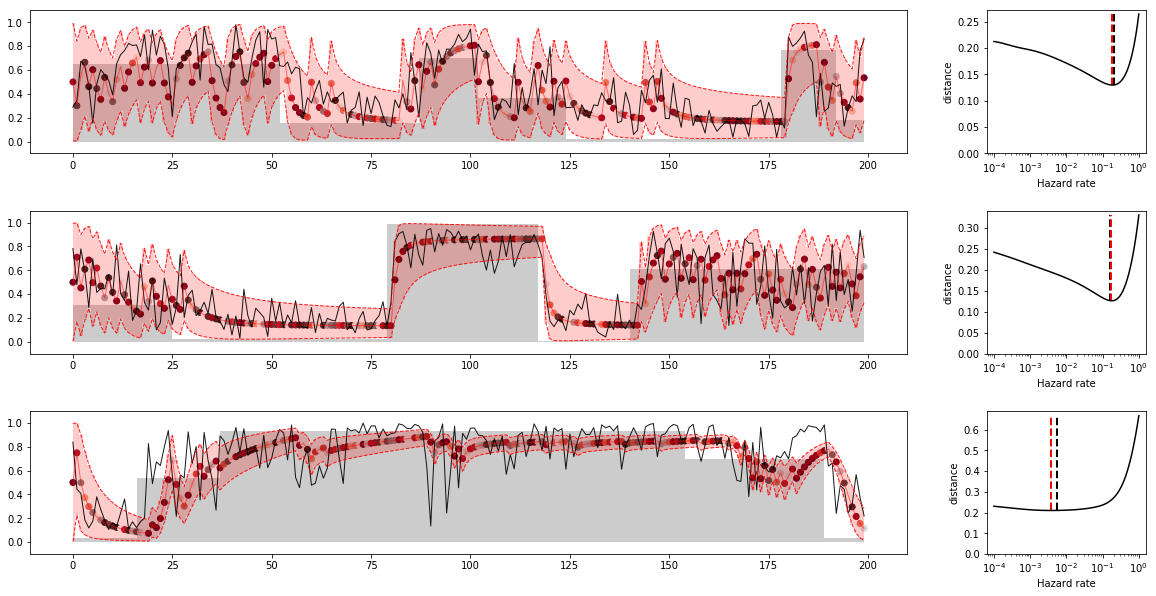

LB
block 0 --> tau_sujet=25.0 , h_sujet=0.04000 , tau_opt=23.6 , h_opt=0.04229
block 1 --> tau_sujet=8.5 , h_sujet=0.11834 , tau_opt=14.8 , h_opt=0.06734
block 2 --> tau_sujet=20.1 , h_sujet=0.04974 , tau_opt=19.6 , h_opt=0.05094


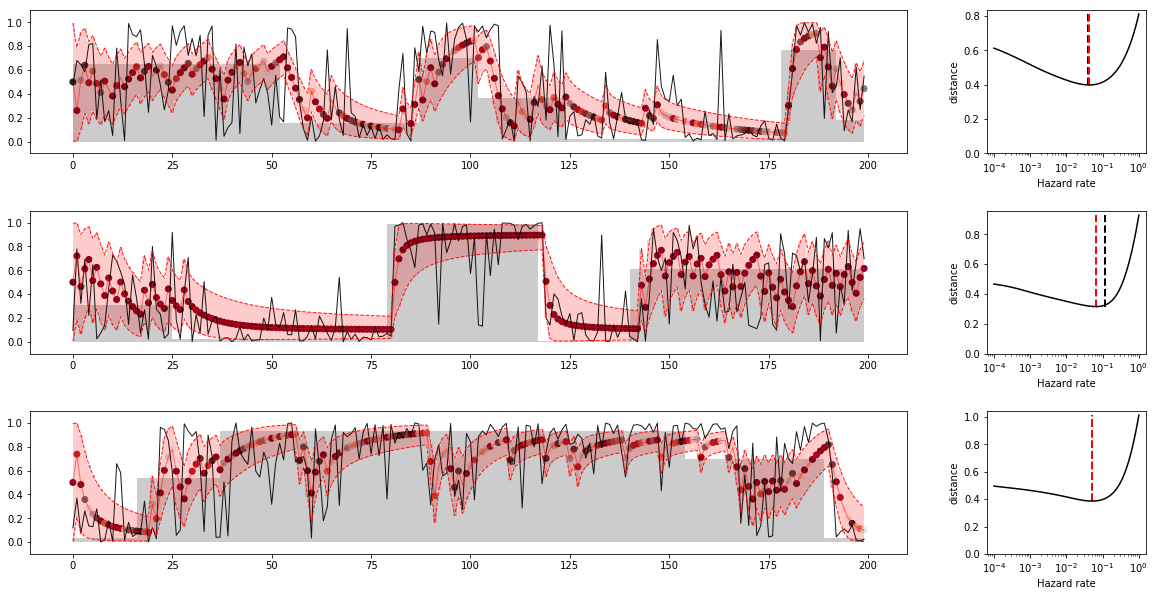

OP
block 0 --> tau_sujet=6.2 , h_sujet=0.16173 , tau_opt=7.7 , h_opt=0.12915
block 1 --> tau_sujet=5.3 , h_sujet=0.18930 , tau_opt=5.9 , h_opt=0.17074
block 2 --> tau_sujet=7.7 , h_sujet=0.12904 , tau_opt=11.2 , h_opt=0.08902


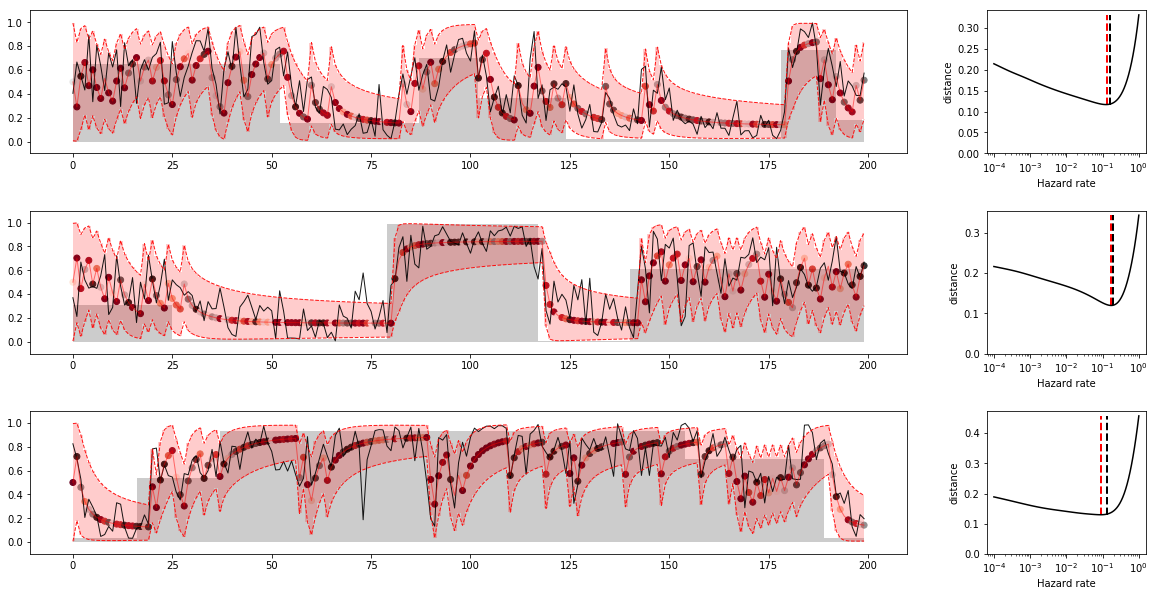

RS
block 0 --> tau_sujet=1.1 , h_sujet=0.93480 , tau_opt=1.2 , h_opt=0.83022
block 1 --> tau_sujet=2.7 , h_sujet=0.37401 , tau_opt=4.0 , h_opt=0.24771
block 2 --> tau_sujet=3.1 , h_sujet=0.31822 , tau_opt=4.4 , h_opt=0.22570


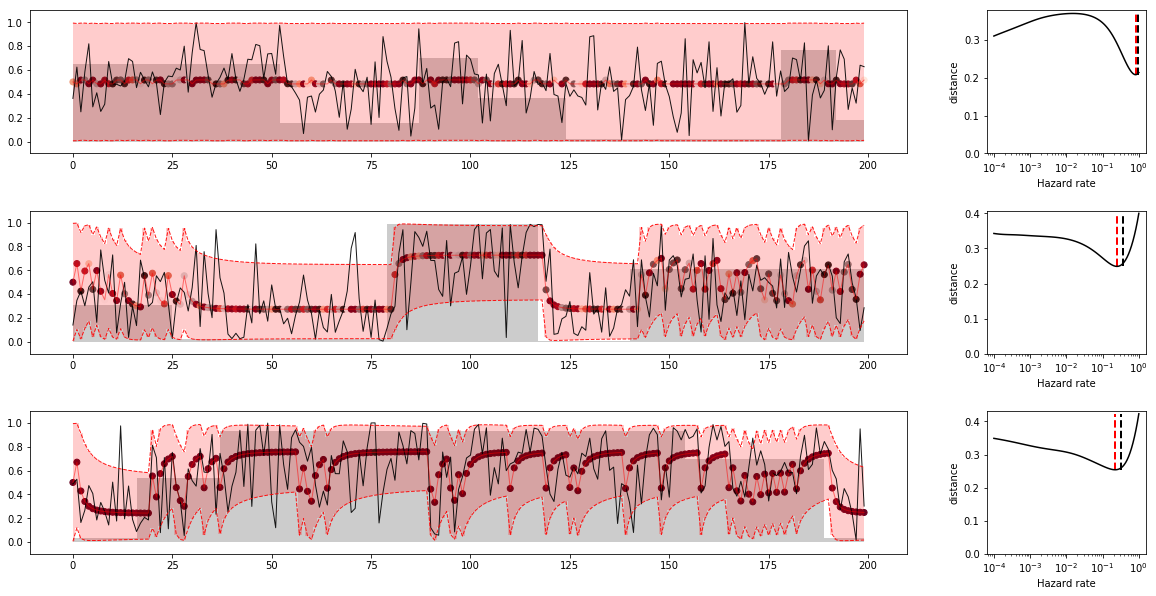

SR
block 0 --> tau_sujet=3.7 , h_sujet=0.26909 , tau_opt=4.4 , h_opt=0.22570
block 1 --> tau_sujet=4.6 , h_sujet=0.21765 , tau_opt=4.0 , h_opt=0.24771
block 2 --> tau_sujet=44.2 , h_sujet=0.02261 , tau_opt=28.5 , h_opt=0.03511


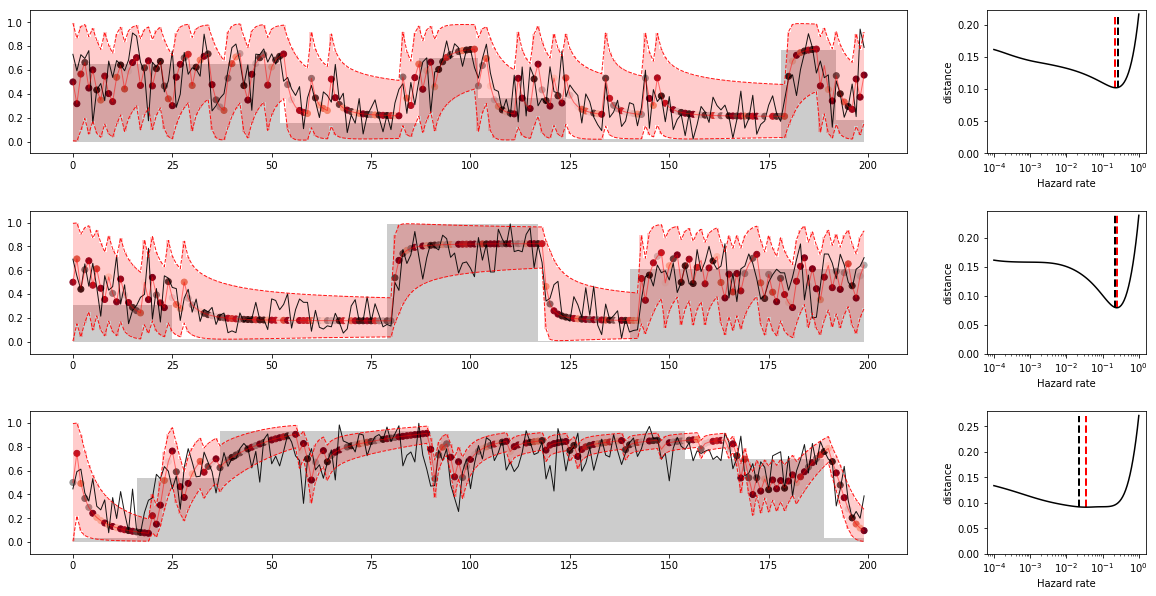

TN
block 0 --> tau_sujet=1.4 , h_sujet=0.70525 , tau_opt=1.7 , h_opt=0.57224
block 1 --> tau_sujet=3.2 , h_sujet=0.30921 , tau_opt=3.4 , h_opt=0.29836
block 2 --> tau_sujet=416.7 , h_sujet=0.00240 , tau_opt=265.6 , h_opt=0.00376


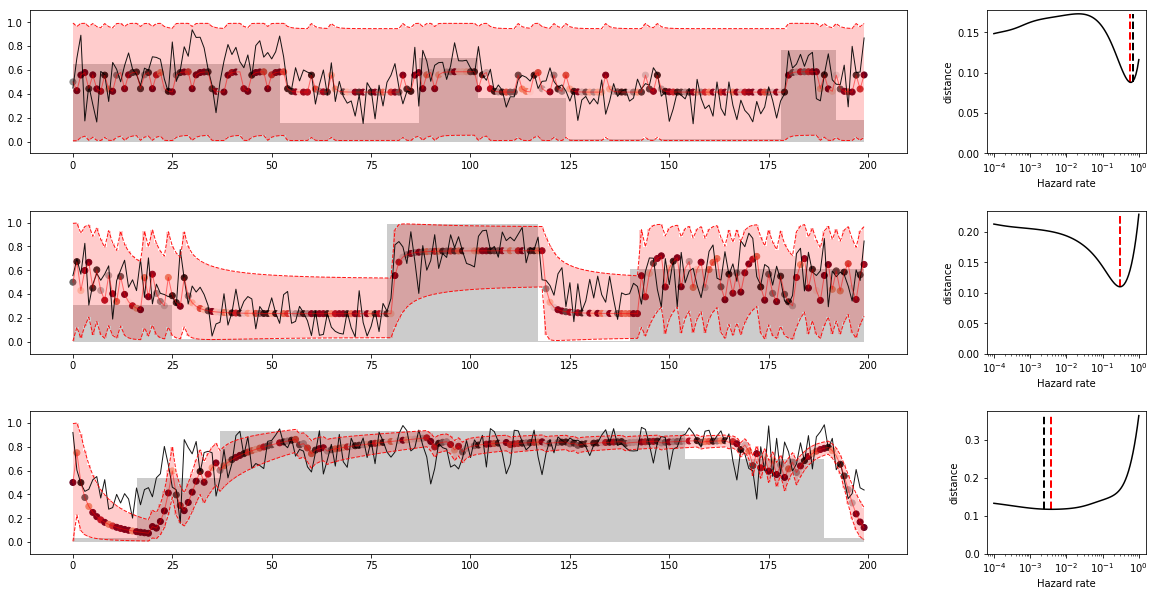

YK
block 0 --> tau_sujet=10.9 , h_sujet=0.09150 , tau_opt=14.8 , h_opt=0.06734
block 1 --> tau_sujet=8.8 , h_sujet=0.11380 , tau_opt=16.3 , h_opt=0.06136
block 2 --> tau_sujet=11.7 , h_sujet=0.08574 , tau_opt=11.2 , h_opt=0.08902


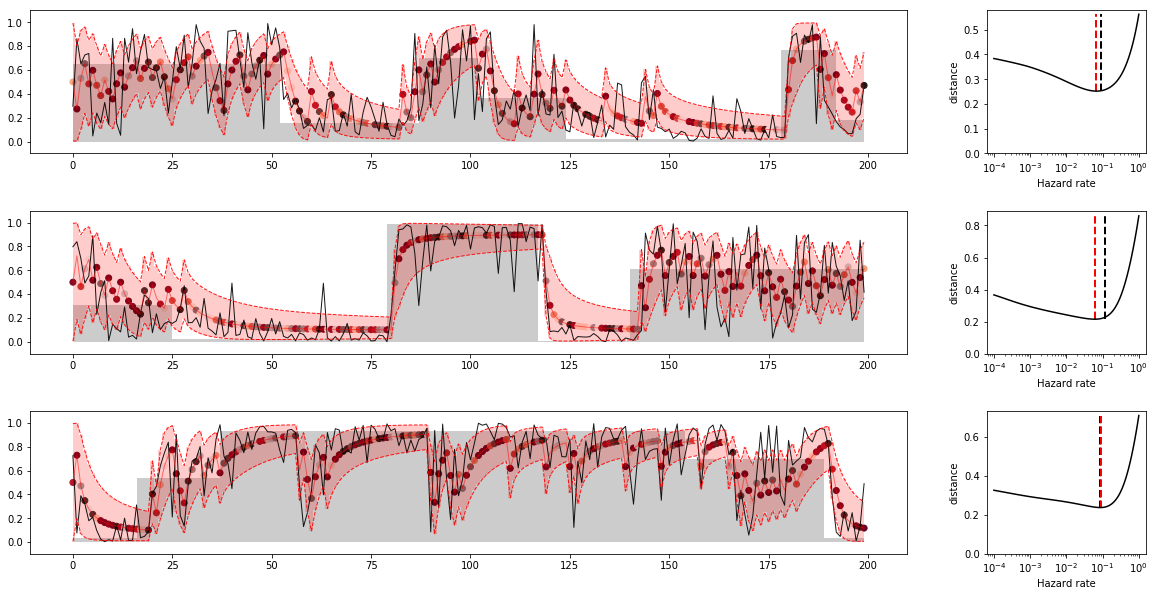

In [14]:
evaluating (new_va_full, h_va)